In [92]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [93]:
batch_size = 16
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2470, 0.2435, 0.2616])])
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Files already downloaded and verified
Files already downloaded and verified


device(type='cuda')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


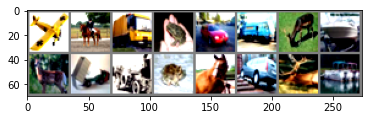

plane horse truck frog  car   truck deer  ship  deer  truck car   frog  horse car   deer  ship 


In [94]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [95]:

class network_g_19(nn.Module):
    #gets 74 ish
    # def __init__(self):
    #     super().__init__()
    #     self.conv1 = nn.Conv2d(3, 64, 3)
    #     self.conv2 = nn.Conv2d(64, 256, 3)
    #     self.conv3 = nn.Conv2d(256, 512, 3)
    #     self.fc1 = nn.Linear(512 * 4, 512)
    #     self.fc2 = nn.Linear(512, 256)
    #     self.fc3 = nn.Linear(256, 128)
    #     self.fc4 = nn.Linear(128, 64)
    #     self.fc5 = nn.Linear(64, 10)
    #     self.dropout1 = nn.Dropout(0.6)
    #     self.dropout2 = nn.Dropout(0.4)
    #     self.pool = nn.MaxPool2d(2, 2)

    # def forward(self, x):
    #     x = F.relu(self.conv1(x))
    #     x = self.pool(x)
    #     x = F.relu(self.conv2(x))
    #     x = self.pool(x)
    #     x = F.relu(self.conv3(x))
    #     x = self.pool(x)
    #     x = torch.flatten(x, 1)
    #     x = F.relu(self.fc1(x))
    #     x = self.dropout1(x)
    #     x = F.relu(self.fc2(x))
    #     x = self.dropout1(x)
    #     x = F.relu(self.fc3(x))
    #     x = self.dropout1(x)
    #     x = F.relu(self.fc4(x))
    #     x = self.dropout2(x)
    #     x = self.fc5(x)
    #     return x
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.6)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.bn1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.bn2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

net = network_g_19()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net.to(device)
criterion.to(device)
net

network_g_19(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b

In [96]:
training_loss_history = []
testing_accuracy_history = []
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            training_loss_history.append(running_loss / 2000)
            running_loss = 0.0
    if True: #get test accuracy on every epoch
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = net(images.cuda())
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.cuda().size(0)
                correct += (predicted == labels.cuda()).sum().item()
        accuracy = 100 * correct / total
        testing_accuracy_history.append(accuracy)
        print(f'Accuracy of the network on the 10000 test images: {accuracy} %')
print('Finished Training')

[1,  2000] loss: 1.783
Accuracy of the network on the 10000 test images: 55.93 %
[2,  2000] loss: 1.098
Accuracy of the network on the 10000 test images: 67.71 %
[3,  2000] loss: 0.865


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.cuda())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.cuda().size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 82.95 %


c:\Users\ivanb\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

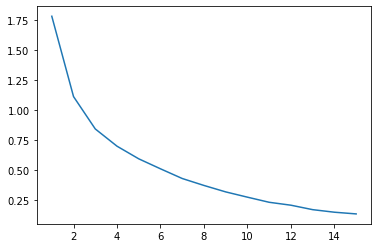

In [ ]:
import seaborn as sns

sns.lineplot(range(1, 16), training_loss_history, markers = 'x')

c:\Users\ivanb\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

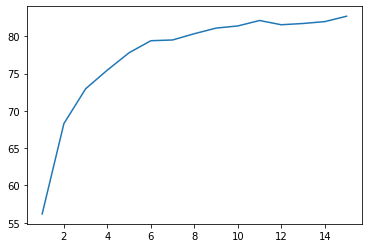

In [ ]:
sns.lineplot(range(1, 16), testing_accuracy_history)

In [ ]:
torch.save(net.state_dict(), "model.pt")

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda())
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.cuda() == prediction:
                correct_pred[classes[label.cuda()]] += 1
            total_pred[classes[label.cuda()]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')




Accuracy for class: plane is 87.1 %
Accuracy for class: car   is 89.5 %
Accuracy for class: bird  is 75.4 %
Accuracy for class: cat   is 69.4 %
Accuracy for class: deer  is 81.0 %
Accuracy for class: dog   is 72.1 %
Accuracy for class: frog  is 87.2 %
Accuracy for class: horse is 87.6 %
Accuracy for class: ship  is 90.3 %
Accuracy for class: truck is 89.5 %


TypeError: histplot() takes from 0 to 1 positional arguments but 2 were given

<BarContainer object of 10 artists>

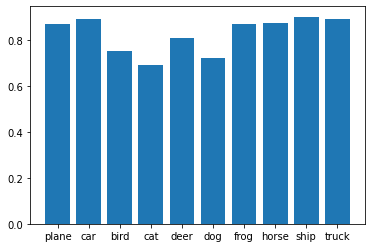

In [ ]:
accuracy_by_class = {}
for classname in correct_pred.keys():
    accuracy_by_class[classname] = correct_pred[classname] / total_pred[classname]
plt.bar(accuracy_by_class.keys(), accuracy_by_class.values())